<a href="https://colab.research.google.com/github/pablonin0/ResFineTune/blob/main/Classification_TransferLearning_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os


In [ ]:
# Data augmentation and normalization for training
data_transforms = {
    'Train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
#Data path
data_dir = "/content/drive/My Drive/Colab Notebooks/Classification Dataset/"
#Load data
Datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
              for x in ['Train', 'Val']}

#Define Train and Validation Dataloaders
dataloaders = {x: torch.utils.data.DataLoader(Datasets[x], batch_size=5,
                                             shuffle=True, num_workers=0)
              for x in ['Train', 'Val']}

dataset_sizes = {x: len(Datasets[x]) for x in ['Train', 'Val']}
print(dataset_sizes)

class_names = Datasets['Val'].classes
print(class_names)

{'Train': 340, 'Val': 60}
['15 Rectangle', '15 circle', '15 square', '15 triangle']


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_model(model, lossFunction, optimizer, scheduler, num_epochs=100):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Val']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = lossFunction(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'Train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'Val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

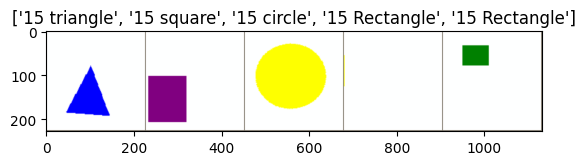

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['Train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def visualize_model(model, num_images=8):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['Val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            percentage = torch.sigmoid(outputs)[0] * 100
            _, indices = torch.sort(outputs, descending=True)
            probs=[percentage[idx].item() for idx in indices[0][:4]]

            classes=[class_names[idx] for idx in indices[0][:4]]

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 5, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
import torchvision
from torchvision import models
import torch.nn as nn

In [ ]:
#Transfer Learning by fineTuning the pretrained Resnet101 Model
#Load Resnet101 pretained Model
#Resnet101 = models.resnet101(pretrained=True)
#If pretained is not working, you can also use weights instead.
Resnet101 = models.resnet101(weights=True)
#print(Resnet101)
#Set the resnet param.requires_grad = True to calculate the gradient,
#so that model fine-tunes the weights of the pretrained network
#by continuing the backpropagation.
for param in Resnet101.parameters():
    param.requires_grad = True

#Get the number of Input features of Resnet last fully connected layer
#because we are going to replace it with new fully connected layer.
in_features = Resnet101.fc.in_features

#Reset the final fully connected layer of the of the pre-trained Resnet.
#Resnet101.fc = nn.Linear(in_features, len(class_names))
Resnet101.fc = nn.Sequential(
    nn.Dropout(p=0.5),  # Puedes ajustar p entre 0.3 y 0.5
    nn.Linear(in_features, len(class_names))
)
#DROPOUT=para combatir el overfitting

Resnet_fineTuning = Resnet101.to(device)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:03<00:00, 47.5MB/s]


In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler

In [ ]:

#Define optimzation algorithm
optimizer = optim.Adam(Resnet_fineTuning.parameters(), lr=0.00001)

# Decay LR by a factor of 0.1 every 7 epochs
Decay_Learning_Rate = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

#Define loss functions
Loss_Function = nn.CrossEntropyLoss()


In [ ]:
model_fineTuning = train_model(Resnet_fineTuning, Loss_Function, optimizer, Decay_Learning_Rate, num_epochs=20)
torch.save(model_fineTuning, "/content/drive/My Drive/Colab Notebooks/Resnet_fineTuning.pth")


Epoch 0/19
----------
Train Loss: 0.7941 Acc: 0.6441
Val Loss: 0.4566 Acc: 0.7833

Epoch 1/19
----------
Train Loss: 0.8229 Acc: 0.6294
Val Loss: 0.4617 Acc: 0.8000

Epoch 2/19
----------
Train Loss: 0.7644 Acc: 0.6618
Val Loss: 0.4748 Acc: 0.7667

Epoch 3/19
----------
Train Loss: 0.8014 Acc: 0.6529
Val Loss: 0.4581 Acc: 0.8333

Epoch 4/19
----------
Train Loss: 0.7780 Acc: 0.6500
Val Loss: 0.4591 Acc: 0.8167

Epoch 5/19
----------
Train Loss: 0.7283 Acc: 0.6647
Val Loss: 0.4784 Acc: 0.8167

Epoch 6/19
----------
Train Loss: 0.7555 Acc: 0.6647
Val Loss: 0.4638 Acc: 0.8000

Epoch 7/19
----------
Train Loss: 0.7620 Acc: 0.6324
Val Loss: 0.4445 Acc: 0.8167

Epoch 8/19
----------
Train Loss: 0.7961 Acc: 0.6647
Val Loss: 0.4501 Acc: 0.8333

Epoch 9/19
----------
Train Loss: 0.7601 Acc: 0.6765
Val Loss: 0.4624 Acc: 0.7833

Epoch 10/19
----------
Train Loss: 0.7744 Acc: 0.6706
Val Loss: 0.4522 Acc: 0.7667

Epoch 11/19
----------
Train Loss: 0.8154 Acc: 0.6441
Val Loss: 0.4404 Acc: 0.7833

Ep

In [ ]:
Resnet_fineTuning = torch.load('/content/drive/My Drive/Colab Notebooks/Resnet_fineTuning.pth',  weights_only=False)

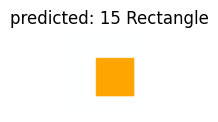

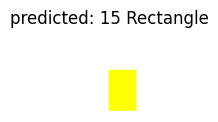

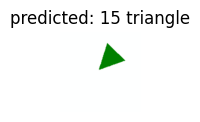

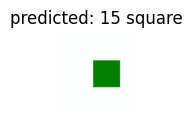

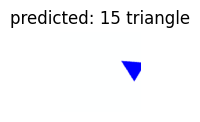

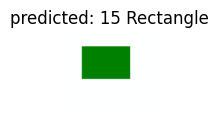

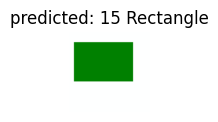

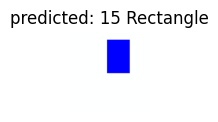

In [ ]:
visualize_model(Resnet_fineTuning)

In [ ]:
pip install ai-edge-torch-nightly torchvision

In [ ]:
!pip install ml-dtypes==0.4.0

  Using cached ml_dtypes-0.4.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached ml_dtypes-0.4.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.2 MB)
  Attempting uninstall: ml-dtypes
    Found existing installation: ml_dtypes 0.5.1
    Uninstalling ml_dtypes-0.5.1:
      Successfully uninstalled ml_dtypes-0.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-nightly 2.20.0.dev20250516 requires ml-dtypes<1.0.0,>=0.5.1, but you have ml-dtypes 0.4.0 which is incompatible.


In [ ]:
import ai_edge_torch
import numpy
import torch
import torchvision

AttributeError: module 'ml_dtypes' has no attribute 'int2'

In [ ]:
resnet18 = torchvision.models.resnet18(torchvision.models.ResNet18_Weights.IMAGENET1K_V1).eval()
sample_inputs = (torch.randn(1, 3, 224, 224),)
torch_output = resnet18(*sample_inputs)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 142MB/s]


In [ ]:
edge_model = ai_edge_torch.convert(resnet18.eval(), sample_inputs)

In [ ]:
edge_output = edge_model(*sample_inputs)

In [ ]:
if (numpy.allclose(
    torch_output.detach().numpy(),
    edge_output,
    atol=1e-5,
    rtol=1e-5,
)):
    print("Inference result with Pytorch and TfLite was within tolerance")
else:
    print("Something wrong with Pytorch --> TfLite")

Inference result with Pytorch and TfLite was within tolerance


In [ ]:
from google.colab import files
edge_model.export('resnet.tflite')

# Download the tflite flatbuffer which can be used with the existing TfLite APIs.
# files.download('resnet.tflite')

FileNotFoundError: [Errno 2] No such file or directory: ''

In [6]:
!git init
!git commit -m "first commit"
!git branch -M main
!git remote add origin https://github.com/pablonin0/ResFineTune.git
!git config --global user.email 'pabloninoperez@mail.com'

Reinitialized existing Git repository in /content/.git/
Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@d480e2c72c75.(none)')
error: remote origin already exists.


In [ ]:
pip install ai-edge-model-explorer

In [ ]:
import model_explorer
model_explorer.visualize('resnet.tflite')

In [ ]:
!pip install torch torchvision onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 83.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:
import torch
import onnx
import torchvision

In [ ]:
# Set  input shape of the model
input_shape = (1, 3, 224, 224)

# Create a dummy input tensor on the correct device
# Assuming Resnet_fineTuning is on the 'device' (cuda:0 or cpu)
dummy_input = torch.randn(input_shape).to(device)

# Export  PyTorch model to ONNX format
# Use the dummy_input that is on the same device as the model
torch.onnx.export(Resnet_fineTuning, dummy_input, 'resnet02.onnx', opset_version=11)

In [ ]:
!pip install --upgrade typeguard

  Attempting uninstall: typeguard
    Found existing installation: typeguard 2.13.3
    Uninstalling typeguard-2.13.3:
      Successfully uninstalled typeguard-2.13.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-addons 0.23.0 requires typeguard<3.0.0,>=2.7, but you have typeguard 4.4.2 which is incompatible.


In [ ]:
!pip install onnx-tf

  Using cached typeguard-2.13.3-py3-none-any.whl.metadata (3.6 kB)
Using cached typeguard-2.13.3-py3-none-any.whl (17 kB)
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
!pip install 'keras<3.0.0' mediapipe-model-maker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.3/133.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18

In [ ]:
!pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 110.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 109.4 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.1
    Uninstalling tensorflow-2.15.1:
      Successfully uninstalled tensorflow-2.15.1
ERROR: pip's dependency re

In [ ]:
# Borra la instalación actual
!pip uninstall -y tensorflow tensorflow-probability

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: tensorflow-probability 0.25.0
Uninstalling tensorflow-probability-0.25.0:
  Successfully uninstalled tensorflow-probability-0.25.0


In [ ]:
# Instala versiones compatibles
!pip install tensorflow==2.13.0 tensorflow-probability==0.20.0 onnx-tf

  Using cached tensorflow-2.13.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
  Using cached tensorflow_probability-0.20.0-py2.py3-none-any.whl.metadata (13 kB)
  Using cached onnx_tf-1.10.0-py3-none-any.whl.metadata (510 bytes)
  Using cached gast-0.4.0-py3-none-any.whl.metadata (1.1 kB)
  Using cached keras-2.13.1-py3-none-any.whl.metadata (2.4 kB)
INFO: pip is looking at multiple versions of onnx to determine which version is compatible with other requirements. This could take a while.
Reason for being yanked: TFP 0.20 should require Python 3.8+
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.2/524.2 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

In [ ]:
# Borra la instalación actual de numpy
!pip uninstall -y numpy

# Instala una versión de numpy compatible con tensorflow==2.13.0
# numpy version 1.24.3 is known to work well with TensorFlow 2.13.0
!pip install numpy==1.24.3

Found existing installation: numpy 1.24.3
Uninstalling numpy-1.24.3:
  Successfully uninstalled numpy-1.24.3
  Using cached numpy-1.24.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.24.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
nibabel 5.3.2 requires typing-extensions>=4.6; python_version < "3.13", but you have typing-extensions 4.5.0 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.13.0 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.13.0 which is incompatible

In [ ]:
!pip uninstall -y numpy tensorflow tensorflow-probability onnx-tf
!pip install numpy==1.25.0 tensorflow==2.13.0 tensorflow-probability==0.20.0 onnx-tf


Found existing installation: numpy 1.24.3
Uninstalling numpy-1.24.3:
  Successfully uninstalled numpy-1.24.3
Found existing installation: tensorflow 2.13.0
Uninstalling tensorflow-2.13.0:
  Successfully uninstalled tensorflow-2.13.0
Found existing installation: tensorflow-probability 0.20.0
Uninstalling tensorflow-probability-0.20.0:
  Successfully uninstalled tensorflow-probability-0.20.0
Found existing installation: onnx-tf 1.10.0
Uninstalling onnx-tf-1.10.0:
  Successfully uninstalled onnx-tf-1.10.0
  Using cached numpy-1.25.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
  Using cached tensorflow-2.13.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
  Using cached tensorflow_probability-0.20.0-py2.py3-none-any.whl.metadata (13 kB)
  Using cached onnx_tf-1.10.0-py3-none-any.whl.metadata (510 bytes)
INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This

In [ ]:
import onnx_tf
print("¡ONNX-TF importado correctamente!")

ModuleNotFoundError: No module named 'onnx_tf'

In [ ]:
import onnx_tf

ModuleNotFoundError: No module named 'onnx_tf'

In [ ]:
# A partir de aqui, ya era el codigo normal, antes de esto fue un intento de convertirlo a TFlite

In [ ]:
#Feature Extractor

In [ ]:
#Transfer Learning with pretrained Resnet101 model as fixed feature extractor
#Load Resnet101 pretained Model
Resnet101 = models.resnet101(pretrained=True)
#If pretained is not working, you can also use weights instead.
#Resnet101 = models.resnet101(weights=True)

#Here, we freeze all the network weights except the final layer.
#We need to set requires_grad = False to freeze the parameters
#so that the gradients are not computed in backward().
for param in Resnet101.parameters():
    param.requires_grad = False

#Get the number of Input features of Resnet last fully connected layer
#because we are going to replace it with new fully connected layer.
in_features = Resnet101.fc.in_features

#Replace the final fully connected layer of the of the pre-trained Resnet.
Resnet101.fc = nn.Linear(in_features, len(class_names))

#Only last replaced layer will be trained and
#the rest of the network is treated as a fixed feature extractor.
Resnet_featureExtractor = Resnet101.to(device)

In [ ]:
#Define loss functions
Loss_Function = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = optim.SGD(Resnet_featureExtractor.fc.parameters(), lr=0.00001)

# Decay LR by a factor of 0.1 every 7 epochs
Decay_Learning_Rate = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
model_featureExtractor = train_model(Resnet_featureExtractor, Loss_Function, optimizer, Decay_Learning_Rate, num_epochs=20)
torch.save(model_featureExtractor, "/content/drive/My Drive/Colab Notebooks/Resnet_featureExtractor.pth")


Epoch 0/19
----------
Train Loss: 1.1138 Acc: 0.3633
Val Loss: 1.0590 Acc: 0.4000

Epoch 1/19
----------
Train Loss: 1.1134 Acc: 0.3601
Val Loss: 1.0393 Acc: 0.4800

Epoch 2/19
----------
Train Loss: 1.1031 Acc: 0.3859
Val Loss: 1.0399 Acc: 0.5600

Epoch 3/19
----------
Train Loss: 1.1000 Acc: 0.3955
Val Loss: 1.0487 Acc: 0.4800

Epoch 4/19
----------
Train Loss: 1.0935 Acc: 0.4148
Val Loss: 1.0585 Acc: 0.4600

Epoch 5/19
----------
Train Loss: 1.0943 Acc: 0.4084
Val Loss: 1.0474 Acc: 0.4600

Epoch 6/19
----------
Train Loss: 1.0801 Acc: 0.4695
Val Loss: 1.0765 Acc: 0.3600

Epoch 7/19
----------
Train Loss: 1.0778 Acc: 0.4148
Val Loss: 1.0433 Acc: 0.5000

Epoch 8/19
----------
Train Loss: 1.0766 Acc: 0.4566
Val Loss: 1.0488 Acc: 0.4600

Epoch 9/19
----------
Train Loss: 1.0849 Acc: 0.4180
Val Loss: 1.0468 Acc: 0.4400

Epoch 10/19
----------
Train Loss: 1.0855 Acc: 0.4759
Val Loss: 1.0352 Acc: 0.4600

Epoch 11/19
----------
Train Loss: 1.0864 Acc: 0.4212
Val Loss: 1.0320 Acc: 0.5200

Ep

In [ ]:
Resnet_featureExtractor = torch.load('/content/drive/My Drive/Colab Notebooks/Resnet_featureExtractor.pth')

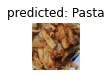

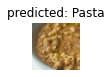

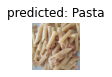

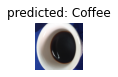

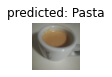

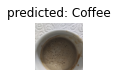

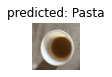

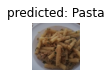

In [ ]:
visualize_model(Resnet_featureExtractor)
